In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [4]:
!pip install transformers

     |████████████████████████████████| 573kB 9.1MB/s 
     |████████████████████████████████| 1.0MB 59.7MB/s 
     |████████████████████████████████| 3.7MB 53.0MB/s 
     |████████████████████████████████| 890kB 60.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=3442dfc1ebd41914f429af8bed1d96f0c0a1524a22421ca71fa153e7674f1589
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [0]:
import os
import json
import tensorflow as tf
from tensorflow import keras
import numpy as np
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from tqdm import tqdm

In [0]:
sen1_test = []
sen2_test = []
res_test = []
sen1_train = []
sen2_train = []
res_train = []
resp = urlopen("https://nlp.stanford.edu/projects/snli/snli_1.0.zip")
zipfile = ZipFile(BytesIO(resp.read()))
for line in zipfile.open('snli_1.0/snli_1.0_train.jsonl').readlines():
    x = json.loads(line)
    k = 0
    y = -1
    if x['gold_label'] == "contradiction":
        y = 0
        k = 1
    elif x['gold_label'] == "neutral":
        y = 1
        k = 1
    elif x['gold_label'] == "entailment":
        y = 2
        k = 1
    if k==1:
        sen1_train.append(x['sentence1'].lower())
        sen2_train.append(x['sentence2'].lower())
        res_train.append(y)
for line in zipfile.open('snli_1.0/snli_1.0_test.jsonl').readlines():
    x = json.loads(line)
    k = 0
    y = -1
    if x['gold_label'] == "contradiction":
        y = 0
        k = 1
    elif x['gold_label'] == "neutral":
        y = 1
        k = 1
    elif x['gold_label'] == "entailment":
        y = 2
        k = 1
    if k==1:
        sen1_test.append(x['sentence1'].lower())
        sen2_test.append(x['sentence2'].lower())
        res_test.append(y)

In [7]:
print(len(res_train))
print(sen1_train[0])
print(sen2_train[0])
print(res_train[0])
print(len(res_test))
print(sen1_test[0])
print(sen2_test[0])
print(res_test[0])

549367
a person on a horse jumps over a broken down airplane.
a person is training his horse for a competition.
1
9824
this church choir sings to the masses as they sing joyous songs from the book at a church.
the church has cracks in the ceiling.
1


In [8]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [0]:
MAX_LENGTH = 64
VALIDATION_SIZE = 0.95
BATCH_SIZE = 128
EPOCHS = 3

In [0]:
input_ids = []
attention_masks = []

# For every sentence...
for i in range(len(res_train)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sen1_train[i],
                        sen2_train[i],
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
res_train = torch.tensor(res_train)

In [11]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, res_train)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(VALIDATION_SIZE * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

521,898 training samples
27,469 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = BATCH_SIZE

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [13]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = EPOCHS

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [18]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  4,078.    Elapsed: 0:00:49.
  Batch    80  of  4,078.    Elapsed: 0:01:40.
  Batch   120  of  4,078.    Elapsed: 0:02:30.
  Batch   160  of  4,078.    Elapsed: 0:03:21.
  Batch   200  of  4,078.    Elapsed: 0:04:11.
  Batch   240  of  4,078.    Elapsed: 0:05:02.
  Batch   280  of  4,078.    Elapsed: 0:05:52.
  Batch   320  of  4,078.    Elapsed: 0:06:43.
  Batch   360  of  4,078.    Elapsed: 0:07:33.
  Batch   400  of  4,078.    Elapsed: 0:08:24.
  Batch   440  of  4,078.    Elapsed: 0:09:14.
  Batch   480  of  4,078.    Elapsed: 0:10:05.
  Batch   520  of  4,078.    Elapsed: 0:10:55.
  Batch   560  of  4,078.    Elapsed: 0:11:46.
  Batch   600  of  4,078.    Elapsed: 0:12:36.
  Batch   640  of  4,078.    Elapsed: 0:13:27.
  Batch   680  of  4,078.    Elapsed: 0:14:18.
  Batch   720  of  4,078.    Elapsed: 0:15:08.
  Batch   760  of  4,078.    Elapsed: 0:15:59.
  Batch   800  of  4,078.    Elapsed: 0:16:49.
  Batch   840  of

In [19]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.42,0.33,0.88,1:25:52,0:01:35
2,0.29,0.32,0.89,1:25:59,0:01:35
3,0.24,0.32,0.89,1:25:59,0:01:35


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


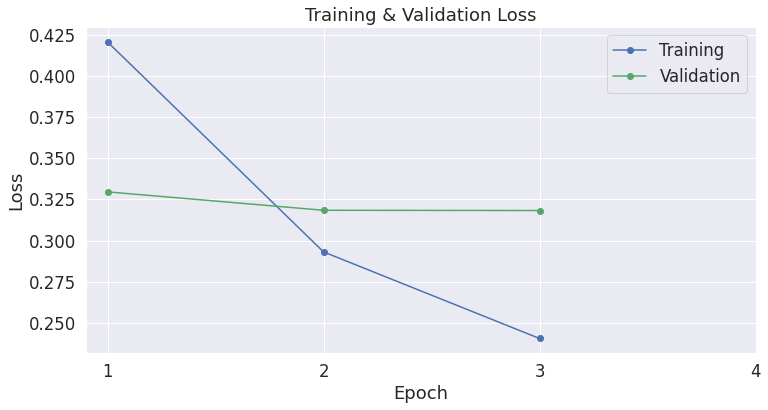

In [20]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [0]:
torch.save(model, './model.pt')

In [0]:
torch.save(model.state_dict(), './model_state_dict.pt')

In [0]:
input_ids = []
attention_masks = []

# For every sentence...
for i in range(len(res_test)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sen1_test[i],                      # Sentence to encode.
                        sen2_test[i],
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
res_test = torch.tensor(res_test)

# Set the batch size.  
batch_size = 128  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, res_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [24]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 9,824 test sentences...
    DONE.


In [25]:
sz = len(predictions)
acc = 0
for i in range(sz):
    if predictions[i] == true_labels[i]:
        acc+=1
print(acc*100/sz)

0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


In [26]:
len(predictions[0][0])

3

In [27]:
true_labels[0]

array([1, 2, 0, 1, 2, 0, 2, 1, 0, 1, 2, 0, 2, 2, 0, 0, 2, 1, 2, 0, 1, 0,
       2, 1, 1, 0, 2, 2, 1, 0, 0, 2, 2, 2, 1, 0, 1, 2, 0, 2, 1, 0, 0, 2,
       1, 1, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 2, 0, 1, 2, 0, 1, 1, 2, 0, 2,
       1, 1, 0, 1, 2, 0, 2, 1, 0, 2, 1, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 1,
       2, 1, 0, 2, 1, 2, 0, 0, 2, 1, 1, 2, 0, 1, 2, 0, 2, 1, 2, 0, 2, 2,
       2, 0, 1, 2, 0, 1, 2, 0, 0, 2, 1, 1, 0, 1, 2, 0, 1, 2])

In [28]:
true_labels[1]

array([0, 0, 1, 2, 1, 2, 0, 2, 0, 1, 2, 0, 1, 1, 2, 0, 1, 0, 2, 1, 1, 0,
       2, 1, 0, 0, 1, 2, 1, 0, 2, 1, 2, 0, 1, 1, 0, 2, 0, 1, 0, 2, 2, 2,
       0, 1, 2, 0, 1, 1, 0, 2, 1, 2, 1, 1, 2, 0, 0, 1, 2, 2, 1, 0, 2, 1,
       0, 2, 0, 1, 0, 1, 2, 1, 0, 1, 2, 0, 2, 1, 0, 0, 2, 1, 0, 2, 1, 2,
       1, 0, 2, 0, 1, 1, 2, 0, 2, 2, 0, 0, 2, 2, 1, 0, 1, 1, 2, 0, 2, 0,
       1, 0, 1, 2, 2, 2, 0, 2, 1, 0, 1, 0, 2, 0, 2, 1, 1, 0])

In [29]:
predictions[0][0]

array([ 2.1006656,  0.9454557, -3.4281952], dtype=float32)

In [30]:
predictions[0][1]

array([-3.8194363,  0.3100642,  3.2787828], dtype=float32)

In [31]:
predictions[0][2]

array([ 4.5478086, -0.5532716, -3.8521395], dtype=float32)

In [32]:
len(predictions)

77

In [33]:
len(predictions[0])

128

In [34]:
len(predictions[0][0])

3

In [35]:
len(true_labels)

77

In [36]:
len(true_labels[0])

128

In [0]:
#predictions = 77 X 128 X 3
#truelabels = 77 X 128

In [0]:
with open('./predictions.txt', "w") as file:
    for item in predictions:
        for it in item:
            file.write(str(it))

In [0]:
with open('./true_labels.txt', "w") as file:
    for item in true_labels:
        for it in item:
            file.write(str(it))

In [0]:
with open('./true_val.txt', "w") as file:
    for it in true_labels:
        for item in it:
            if item == 0:
                file.write("contradiction\n")
            elif item == 1:
                file.write("neutral\n")
            elif item == 2:
                file.write("entailment\n")
            else:
                pass

In [0]:
mypredict = []
for item in predictions:
    for it in item:
        i = np.argmax(it)
        mypredict.append(i)


In [42]:
len(mypredict)

9824

In [43]:
sz = len(mypredict)
acc = 0
for i in range(sz):
    if mypredict[i] == res_test[i]:
        acc+=1
print(acc*100/sz)
with open('./dl.txt', "w") as file:
    for item in mypredict:
        if item == 0:
            file.write("contradiction\n")
        elif item == 1:
            file.write("neutral\n")
        elif item == 2:
            file.write("entailment\n")
        else:
            pass

90.48249185667753


In [44]:
print(acc)

8889


In [0]:
mytrue_labels = []
for item in true_labels:
    for it in item:
        mytrue_labels.append(it)

In [46]:
acc2 = 0
for i in range(len(mypredict)):
    j = int(i/len(true_labels))
    if mypredict[i] == mytrue_labels[i]:
        acc2 += 1
acc2

8889